In [1]:
import wandb
import os
import pandas as pd
import time
%matplotlib inline
import importlib
from common import common
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [3]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project/work/common/common.py'>

In [ ]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TOP_FEATURES_NUM = 5

In [5]:
# project name should correspond to dataset below
# project_name = "kdd"
# project_name = "cicids"
# project_name = "unsw"
# project_name = "thyroid"
# project_name = "cirrhosis"
project_name = "heart"
# project_name = "hepatitis"

In [6]:
if project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    0
dtype: int64


In [7]:
# Should already be one hot encoded and label encoded
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True
0,63,145.0,233.0,150.0,2.3,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,67,160.0,286.0,108.0,1.5,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,67,120.0,229.0,129.0,2.6,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37,130.0,250.0,187.0,3.5,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,41,130.0,204.0,172.0,1.4,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
all_df.shape

(918, 19)

In [9]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [10]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [11]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(734, 18) (184, 18) (734,) (184,)


In [12]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,age,trestbps,chol,thalch,oldpeak,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,num
797,51,132.286047,339.0,137.545665,0.878788,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
25,50,120.000000,219.0,158.000000,1.600000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
84,52,120.000000,325.0,172.000000,0.200000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
10,57,140.000000,192.0,148.000000,0.400000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
344,40,140.000000,289.0,172.000000,0.878788,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [13]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [14]:
X_test_scaled_df.head()

,age,trestbps,chol,thalch,oldpeak,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True
670,0.574961,-1.232904,-0.115841,-1.712141,-0.399443,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
30,1.653195,0.430317,-0.125287,0.542388,0.729958,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
377,-0.934568,0.430317,-0.408679,-0.604653,-0.399443,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
535,-0.826745,-0.124090,-0.446464,-1.000185,-0.399443,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
809,0.143667,0.002650,-0.011930,0.010227,-0.399443,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [15]:
seconds = time.time()

benign = 2359289
minor_type_counts = all_df[TARGET_COLUMN].value_counts()
minor_type_dict = minor_type_counts.to_dict()
print('minor_type_dict', minor_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 3  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue 
    
    common.create_dataset_for_label(label, name, benign, minor_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

minor_type_dict {0: 411, 1: 263, 2: 109, 3: 107, 4: 28}
Slight Presence.csv created with 674 rows. (411 major and 263 minor rows)
Presence.csv created with 436 rows. (327 major and 109 minor rows)
Moderate Presence.csv created with 428 rows. (321 major and 107 minor rows)
High Presence.csv created with 112 rows. (84 major and 28 minor rows)
All datasets created successfully!
Total operation time: = 0.005740165710449219 seconds


In [16]:
len(main_labels)

19

csv_files ['High Presence.csv', 'Moderate Presence.csv', 'Slight Presence.csv', 'Presence.csv']
Processing CSV file: High Presence.csv
High Presence importance list:
High Presence 
                           importance
Features                            
oldpeak                     0.265286
cp_asymptomatic             0.114803
age                         0.111874
thalch                      0.094303
trestbps                    0.078319
exang_True                  0.054557
chol                        0.050550
exang_False                 0.043146
restecg_lv hypertrophy      0.030703
restecg_normal              0.029984
fbs_False                   0.025964
sex_Male                    0.024096
fbs_True                    0.023461
sex_Female                  0.015502
cp_atypical angina          0.011737
cp_typical angina           0.011012
restecg_st-t abnormality    0.009451
cp_non-anginal              0.005251 



High Presence=["oldpeak","cp_asymptomatic","age","thalch","trestbps"]


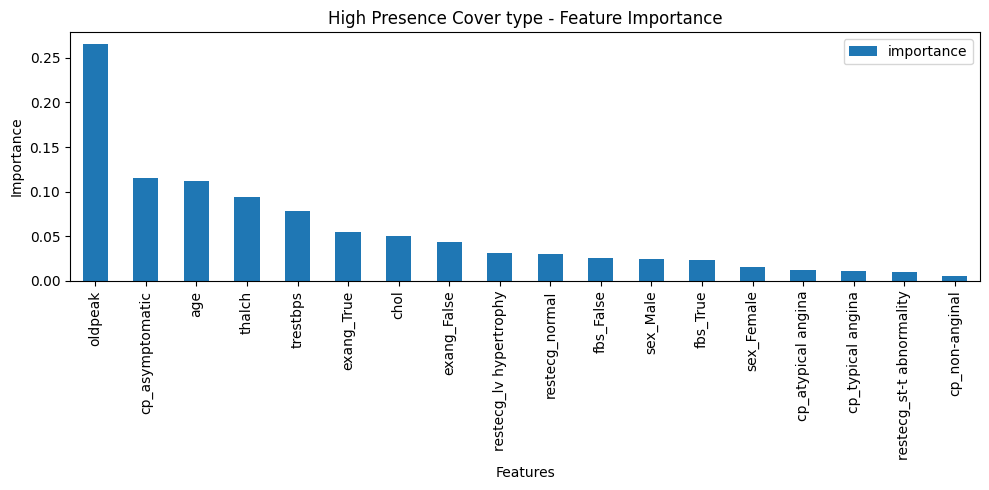

-----------------------------------------------------------------------------------------------




Processing CSV file: Moderate Presence.csv
Moderate Presence importance list:
Moderate Presence 
                           importance
Features                            
thalch                      0.151168
oldpeak                     0.120052
age                         0.118113
exang_True                  0.103351
chol                        0.099293
cp_asymptomatic             0.084000
exang_False                 0.078231
trestbps                    0.073393
fbs_False                   0.027356
fbs_True                    0.024071
sex_Male                    0.020989
cp_atypical angina          0.020331
sex_Female                  0.016429
cp_non-anginal              0.015817
restecg_st-t abnormality    0.014848
restecg_lv hypertrophy      0.014437
restecg_normal              0.012915
cp_typical angina           0.005206 



Moderate Presence=["thalch","oldpeak","age","exang_True","

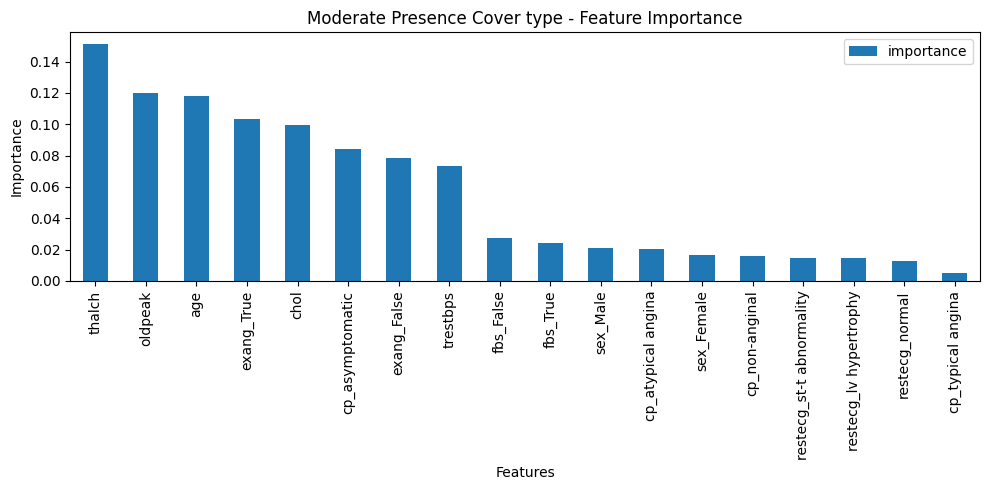

-----------------------------------------------------------------------------------------------




Processing CSV file: Slight Presence.csv
Slight Presence importance list:
Slight Presence 
                           importance
Features                            
thalch                      0.133209
chol                        0.125301
cp_asymptomatic             0.116510
age                         0.114963
trestbps                    0.102399
oldpeak                     0.095876
exang_True                  0.066989
exang_False                 0.048145
cp_atypical angina          0.029322
sex_Female                  0.026647
restecg_normal              0.020686
fbs_False                   0.020180
fbs_True                    0.020117
cp_non-anginal              0.019551
sex_Male                    0.019178
restecg_st-t abnormality    0.017846
restecg_lv hypertrophy      0.013187
cp_typical angina           0.009893 



Slight Presence=["thalch","chol","cp_asymptomatic","age","trestb

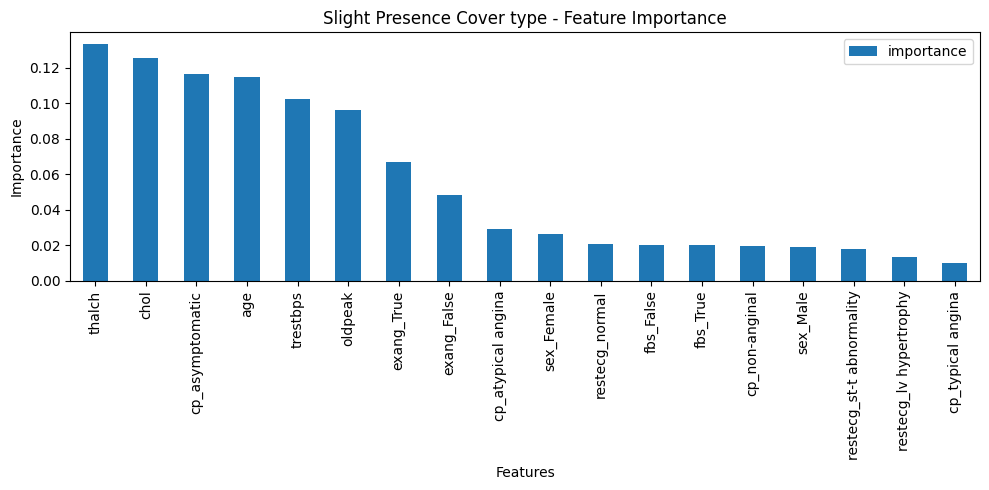

-----------------------------------------------------------------------------------------------




Processing CSV file: Presence.csv
Presence importance list:
Presence 
                           importance
Features                            
oldpeak                     0.136648
cp_asymptomatic             0.132727
thalch                      0.124996
age                         0.121218
chol                        0.099615
trestbps                    0.080810
exang_True                  0.061658
exang_False                 0.043060
fbs_True                    0.035161
fbs_False                   0.034888
sex_Male                    0.025581
cp_atypical angina          0.019573
sex_Female                  0.019079
restecg_st-t abnormality    0.017426
restecg_normal              0.014686
cp_non-anginal              0.012715
restecg_lv hypertrophy      0.011638
cp_typical angina           0.008521 



Presence=["oldpeak","cp_asymptomatic","thalch","age","chol"]


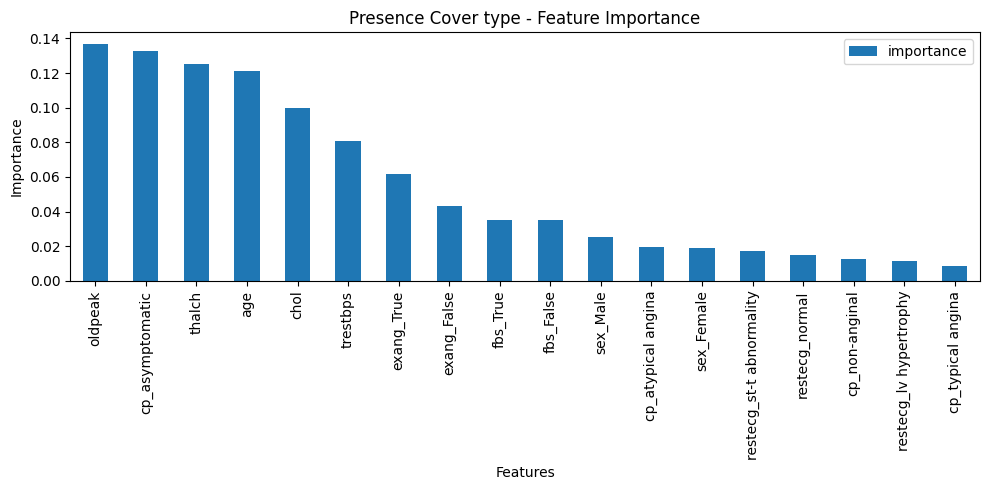

-----------------------------------------------------------------------------------------------




feature_importances: {'High Presence': ['oldpeak', 'cp_asymptomatic', 'age', 'thalch', 'trestbps'], 'Moderate Presence': ['thalch', 'oldpeak', 'age', 'exang_True', 'chol'], 'Slight Presence': ['thalch', 'chol', 'cp_asymptomatic', 'age', 'trestbps'], 'Presence': ['oldpeak', 'cp_asymptomatic', 'thalch', 'age', 'chol']}
Total operation time: = 1.802046537399292 seconds


In [ ]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}
model_name = "svm"

# Linear way
for csv in csv_files:
    label, important_features, svm, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        top_features_num=TOP_FEATURES_NUM,
        scaler=scaler,
        model_name=model_name)
    feature_importances[label] = important_features
    SVMs[label] = svm
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [18]:
seconds = time.time()

# Define the model
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_scaled_df, y_train_df)

# Predict classes for the test set
test_predictions = knn.predict(X_test_scaled_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [1 0 0 0 3 2 0 1 1 3 2 1 2 1 2 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 3 2
 1 1 0 0 2 1 3 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 2 1 1 3 0 0 0 0 0 0 0 1 0 0 0
 3 0 1 0 1 0 3 0 0 0 1 1 0 1 2 0 0 0 1 0 3 2 0 0 3 0 0 1 1 1 0 1 0 0 0 0 1
 0 3 1 0 4 1 1 2 1 0 0 0 0 0 1 2 0 0 1 0 0 0 0 0 1 0 3 2 0 1 0 0 1 0 0 0 0
 1 0 2 0 1 2 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 2 0 2 0 1 1 0 0 2 2 0 1 1 4 0]
Total operation time: =  0.07518625259399414 seconds


Multiclass Classification Evaluation


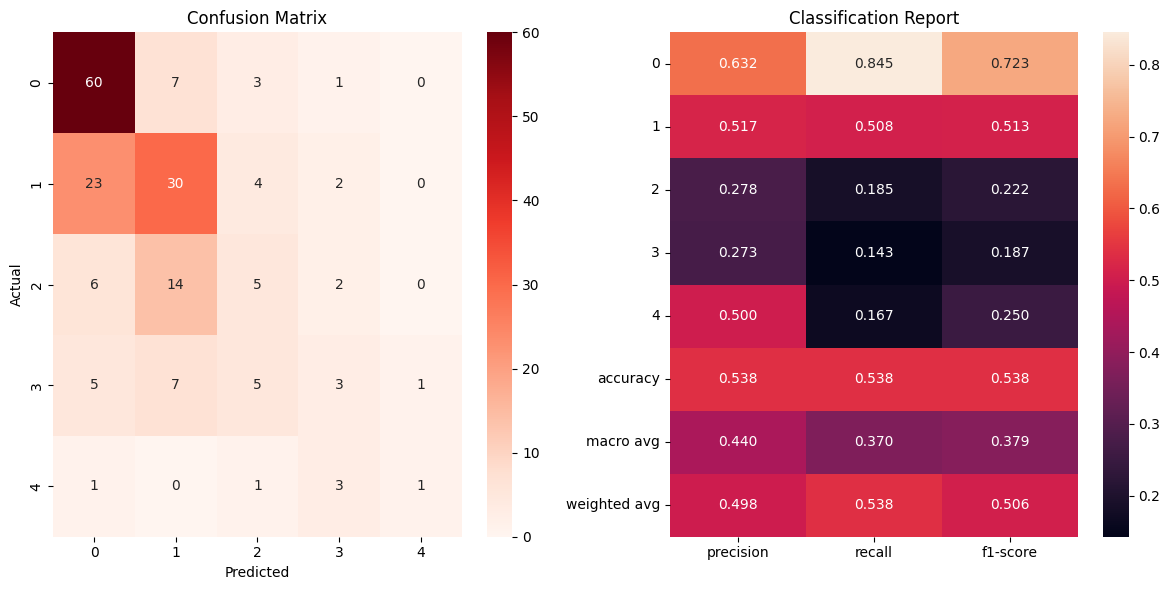

Accuracy: 0.5380434782608695


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.53804
f1-score_avg,0.50554
precision_avg,0.49775
recall_avg,0.53804


In [19]:
pn = "experimental-pipeline-1-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [20]:
seconds = time.time()

def predict_svm(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    svm_model = SVMs[predicted_label]
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    # print(svm_prediction)
    return NORMAL_TARGET if svm_prediction == 1 else INV_TARGET_DICT[predicted_label]
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        prediction = NORMAL_TARGET

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        prediction = predict_svm(predicted_label, test_instance_df)

    return i, prediction

# Run all test data instances in parallel and retain order
svm_predictions = [None] * len(X_test_scaled_df)

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        svm_predictions[idx] = prediction 

print("Total operation time: = ", time.time() - seconds, "seconds")

Total operation time: =  0.237684965133667 seconds


SVM Evaluation (overall)


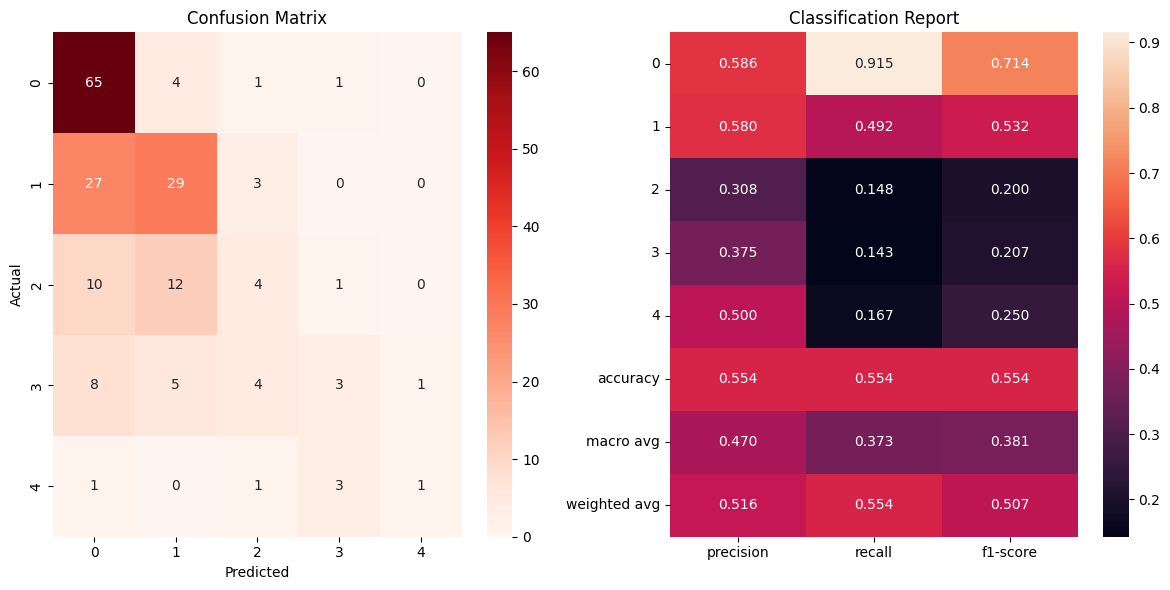

Accuracy: 0.5543478260869565


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.55435
f1-score_avg,0.50736
precision_avg,0.51619
recall_avg,0.55435


In [21]:
# Evaluate SVM on all test data
pn = "experimental-pipeline-1-" + project_name
wandb.init(project=pn, name="final")

final_svm_predictions_df = pd.DataFrame(svm_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_svm_predictions_df, heading='SVM Evaluation (overall)')
wandb.finish()